In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import json
import numpy as np 
import pandas as pd #
from scipy import stats
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from PIL import Image
from sklearn import preprocessing
import string
import langid
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/review-polarity/Review - Polarity - 1.csv
/kaggle/input/review-polarity/Review - Polarity - 6.csv
/kaggle/input/review-polarity/Review - Polarity - 4.csv
/kaggle/input/review-polarity/Review - Polarity - 7.csv
/kaggle/input/review-polarity/Review - Polarity - 3.csv
/kaggle/input/review-polarity/Review - Polarity - 5.csv
/kaggle/input/review-polarity/Review - Polarity - 2.csv
/kaggle/input/non-english-review-id/Non English Review ID.csv
/kaggle/input/review-subjectivity-ordered/Review - Subjectivity.csv
/kaggle/input/yelp-dataset/Dataset_User_Agreement.pdf
/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_checkin.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_tip.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_user.json


## Exploratory Data Analysis - Part1: Understand The Dataset

In [20]:
df_all = df_review_restaurant.merge(df_business_restaurant, on = ['business_id'], how = 'left').merge(df_user_restaurant, on = ['user_id'], how = 'left') 

In [21]:
df_all.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'review_useful',
       'review_funny', 'review_cool', 'text', 'date', 'rev_polarity_x',
       'rev_subjectivity', 'year', 'review_length', 'business_name', 'city',
       'state', 'postal_code', 'latitude', 'longitude', 'business_stars',
       'review_count_x', 'is_open', 'attributes', 'categories', 'user_name',
       'yelping_since', 'user_useful', 'user_funny', 'user_cool', 'elite',
       'friends', 'fans', 'compliment_hot', 'compliment_more',
       'compliment_profile', 'compliment_cute', 'compliment_list',
       'compliment_note', 'compliment_plain', 'compliment_cool',
       'compliment_funny', 'compliment_writer', 'compliment_photos',
       'compliment_total', 'friends_count', 'elites_count', 'review_count_y',
       'average_stars', 'rev_polarity_y', 'user_activity'],
      dtype='object')

In [22]:
df_all.shape

(4709529, 50)

### Descriptive Analysis

(0.0, 60.0)

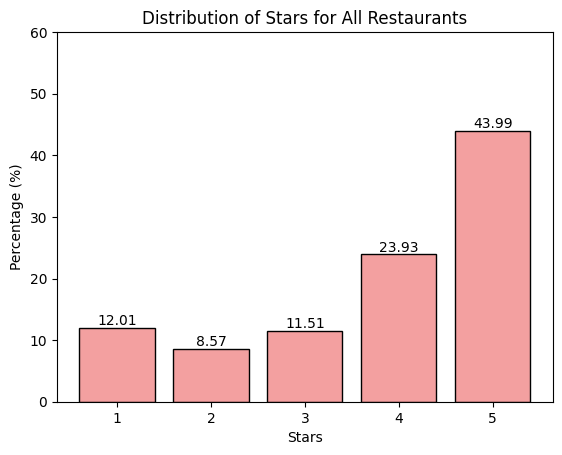

In [23]:
ax = sns.histplot(df_all, 
                  x='stars', discrete=True, shrink = 0.8, stat = 'percent', color='lightcoral')
ax.bar_label(ax.containers[0], fmt='%.2f')
plt.title("Distribution of Stars for All Restaurants")
plt.ylabel('Percentage (%)')
plt.xlabel('Stars')
ax.set_ylim(0,60)

<Axes: >

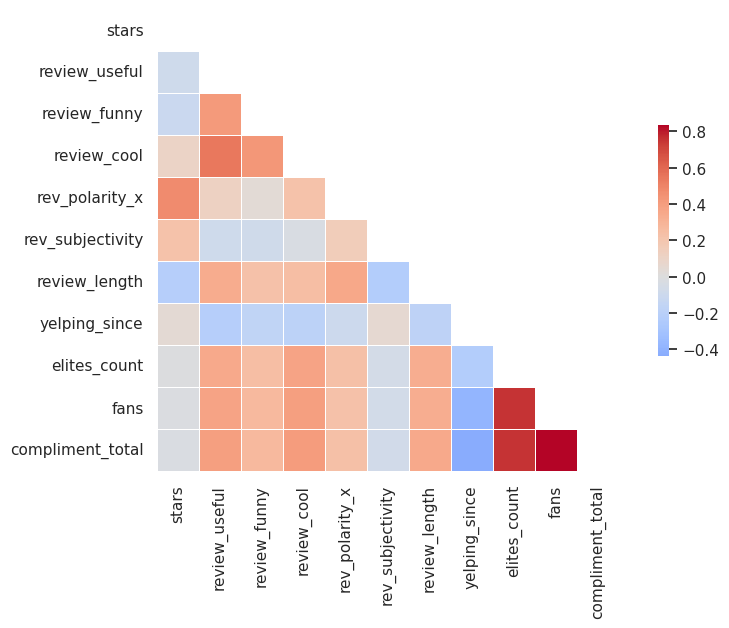

In [20]:
sns.set_theme(style="white")

# Generate a large random dataset
df_corr = df_all[['stars', 'review_useful','review_funny', 'review_cool', 'rev_polarity_x', 'rev_subjectivity', 
                  'review_length', 'yelping_since', 'elites_count', 'fans', 'compliment_total']] 

# Compute the correlation matrix
corr = df_corr.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap = 'coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [21]:
df_corr2 = df_all[['stars','review_length']]      
corr = df_corr2.corr(method='spearman')
corr

,stars,review_length
stars,1.000000,-0.220084
review_length,-0.220084,1.000000


In [22]:
# Calculate Spearman correlation coefficient and p-value
value, p = spearmanr(df_all['stars'], df_all['rev_polarity_x'])
print(f"The Spearmans' Rank Correlation between stars and review polarity is {value}")

The Spearmans' Rank Correlation between stars and review polarity is 0.47128454621682253


In [23]:
neg = df_all[df_all['rev_polarity_x'] <= 0]
print(f"The average stars from users with negative reviews is {neg['stars'].mean()}")
pos = df_all[df_all['rev_polarity_x'] > 0]
print(f"The average stars from users with positive reviews is {pos['stars'].mean()}")

The average stars from users with negative reviews is 1.7978760013632769
The average stars from users with positive reviews is 4.08704263936861


### View the business categories

In [24]:
# an example of business category
df_business_cleaned['categories'][1].lower()

'shipping centers, local services, notaries, mailbox centers, printing services'

In [25]:
all_categories = ','.join(df_business_cleaned['categories'].dropna()).lower().split(',')
all_categories = [category.strip() for category in all_categories]
category_counts = Counter(all_categories)
most_common_categories = category_counts.most_common(20)
len(category_counts)

1312

In [26]:
all_categories = ','.join(df_business_cleaned['categories'].dropna()).lower().split(',')
all_categories = [category.strip() for category in all_categories]
category_counts = Counter(all_categories)
most_common_categories = category_counts.most_common(20)

# find the business_id in different categories
collection = [['a'],['a'],['a'],['a'],['a'], ['a'],['a'],['a'],['a'],['a'],['a'],['a'],['a'],['a'],['a'],['a'],['a'],['a'],['a'],['a']]
for j in range(0, len(df_business_cleaned)):
    text = df_business_cleaned['categories'][j].lower()
    for i in range(0,20):
        if most_common_categories[i][0] in text:
            collection[i].append(df_business_cleaned['business_id'][j])

# count the number of reviews with the business id in a specific category
count_reviews = []
for i in range(0,20):
    n = df_review_all[df_review_cleaned['business_id'].isin(collection[i])].shape[0]
    count_reviews.append(n-1)

categories_name = []
for i in range(0,20):
    categories_name.append(most_common_categories[i][0])

# create the dataframe for visualization
df_review_cat = pd.DataFrame({'Category': categories_name,
                              'Count': count_reviews})
df_review_cat = df_review_cat.sort_values(by = ['Count'], ascending = False).iloc[0:10,]

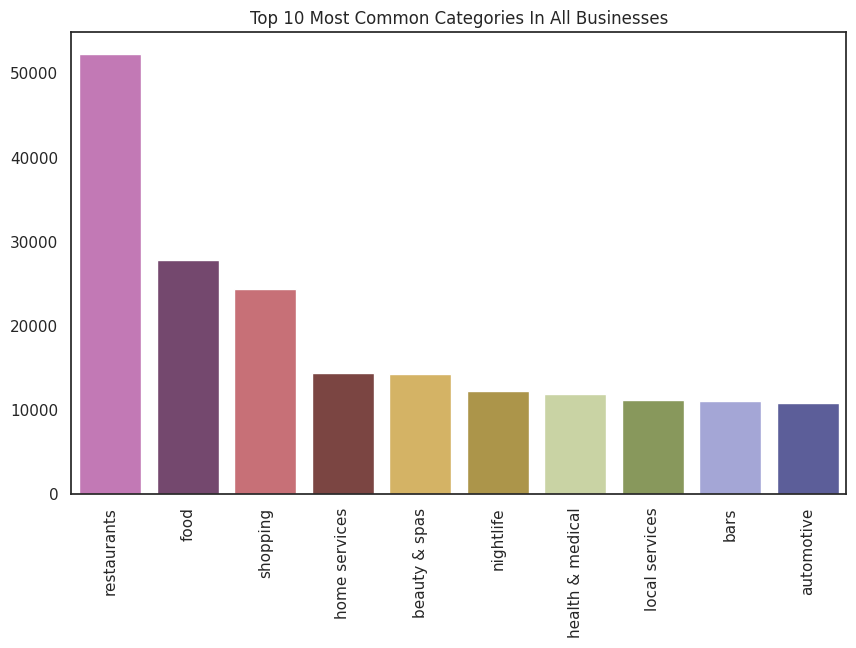

In [27]:
most_common_categories2 = category_counts.most_common(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=[item[0] for item in most_common_categories2], y=[item[1] for item in most_common_categories2], palette = 'tab20b_r')
plt.title('Top 10 Most Common Categories In All Businesses')
plt.xticks(rotation=90)
plt.show()

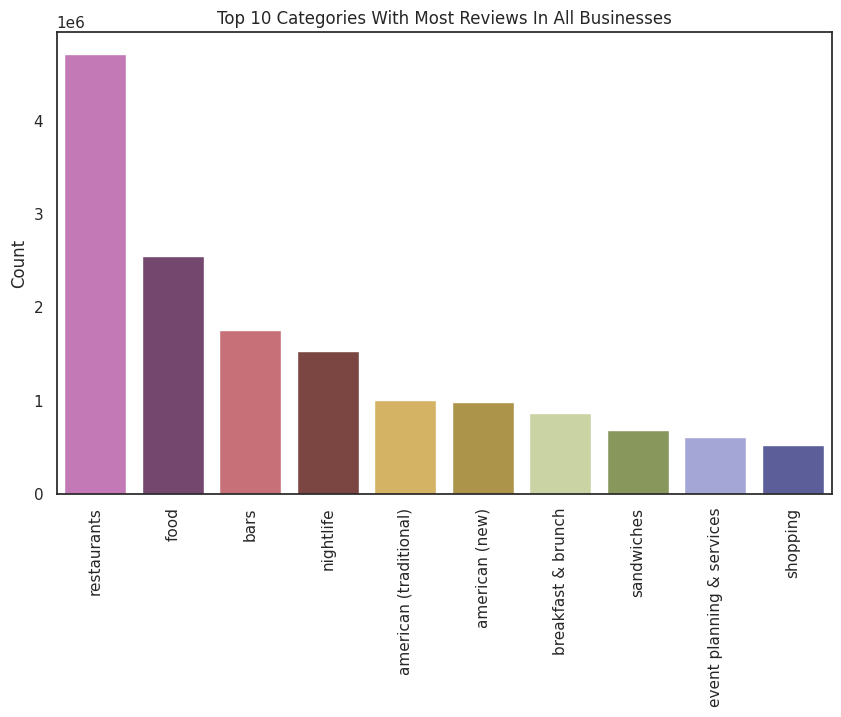

In [28]:
plt.figure(figsize=(10, 6))
sns.barplot(data = df_review_cat, x = 'Category', y = 'Count', palette = 'tab20b_r')
#ax.bar_label(ax.containers[0])
plt.title('Top 10 Categories With Most Reviews In All Businesses')
plt.xticks(rotation=90)
plt.xlabel('')
plt.savefig('review_category.png')

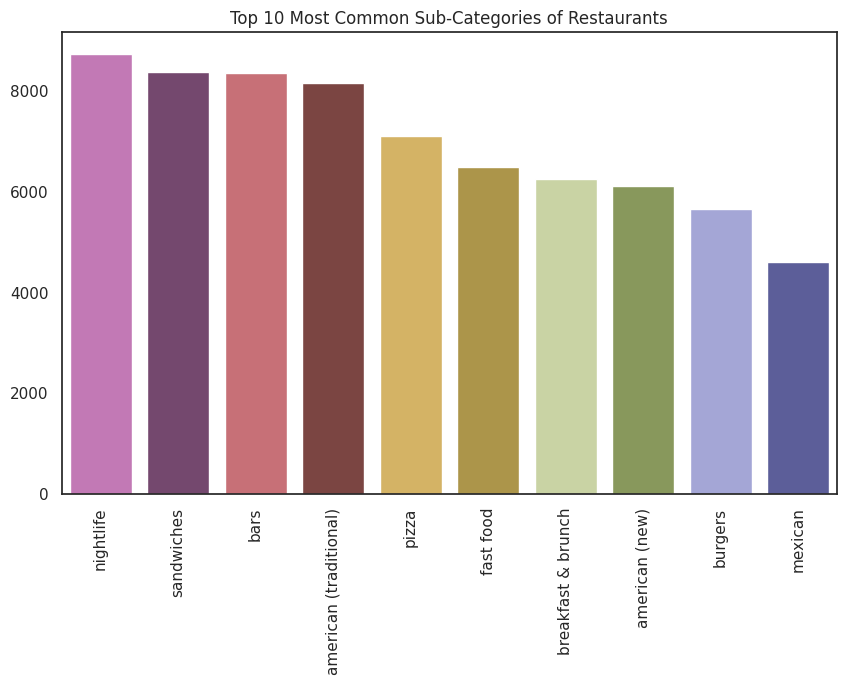

In [29]:
all_subcategories = ','.join(df_business_restaurant['categories'].dropna()).lower().split(',')
all_subcategories = [category.strip() for category in all_subcategories]
subcategory_counts = Counter(all_subcategories)
most_common_subcategories = subcategory_counts.most_common(12)

plt.figure(figsize=(10, 6))
sns.barplot(x=[item[0] for item in most_common_subcategories[2:]], y=[item[1] for item in most_common_subcategories[2:]], palette = 'tab20b_r')
plt.title('Top 10 Most Common Sub-Categories of Restaurants')
plt.xticks(rotation=90)
plt.show()

In [30]:
### top 10 most reviewed sub-categories under restaurant category
most_common_subcategories2 = subcategory_counts.most_common(20)

# find the business_id in different categories
collection = [['a'],['a'],['a'],['a'],['a'], ['a'],['a'],['a'],['a'],['a'],['a'],['a'],['a'],['a'],['a'],['a'],['a'],['a'],['a'],['a']]
for j in range(0, len(df_business_restaurant)):
    text = df_business_restaurant['categories'].iloc[j].lower()
    for i in range(0,20):
        if most_common_subcategories2[i][0] in text:
            collection[i].append(df_business_restaurant['business_id'].iloc[j])

# count the number of reviews with the business id in a specific category
count_reviews = []
avg_stars = []
avg_length = []
avg_stars_sd = []
avg_length_sd = []

for i in range(0,20):
    n = df_all[df_all['business_id'].isin(collection[i])].shape[0]
    count_reviews.append(n)
    avg_stars.append(df_all[df_all['business_id'].isin(collection[i])]['stars'].mean())
    avg_length.append(df_all[df_all['business_id'].isin(collection[i])]['review_length'].mean())
    avg_stars_sd.append(df_all[df_all['business_id'].isin(collection[i])]['stars'].std())
    avg_length_sd.append(df_all[df_all['business_id'].isin(collection[i])]['review_length'].std())
    

categories_name = []
for i in range(0,20):
    categories_name.append(most_common_subcategories2[i][0])
    

# create the dataframe for visualization
df_review_subcat = pd.DataFrame({'Category': categories_name,
                                 'Count': count_reviews,
                                 'Avg_Stars' : avg_stars,
                                 'Avg_length' : avg_length,
                                 'Avg_Stars_sd' : avg_stars_sd,
                                 'Avg_length_sd' : avg_length_sd})
                                

df_review_subcat = df_review_subcat.sort_values(by = ['Count'], ascending = False).iloc[2:12,]

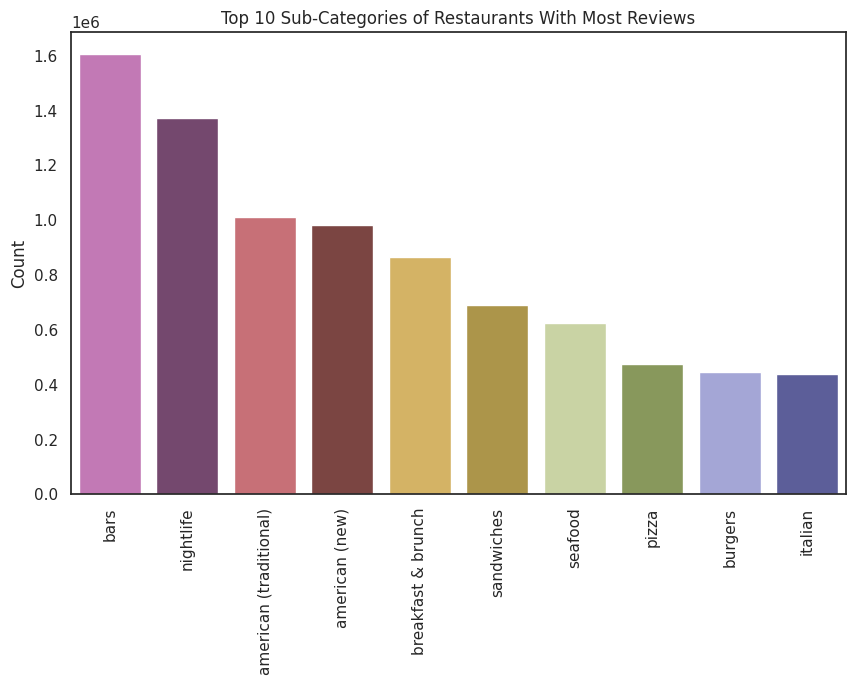

In [31]:
# average stars for different categories 
plt.figure(figsize=(10, 6))
sns.barplot(data = df_review_subcat, x = 'Category', y = 'Count', palette = 'tab20b_r')
#ax.bar_label(ax.containers[0])
plt.title('Top 10 Sub-Categories of Restaurants With Most Reviews')
plt.xticks(rotation=90)
plt.xlabel('')
plt.savefig('review_category.png')

### Trend Analysis

#### The popularity of the top 10 sub-categories of restaurants across 18 years

In [36]:
### the trace of popularity of these 10 subcategories during 17 years 
year_list = df_all['year'].unique().tolist()
year_list.reverse()
subcat_list = df_review_subcat['Category'].tolist()
proportions = [['a'],['a'],['a'],['a'],['a'], ['a'],['a'],['a'],['a'],['a']]  

for k in range(0,10):
    proportions[k] = []
    count = 0
    for i in range(0, len(year_list)):
        df_subyear = df_all[df_all['year'] == year_list[i]]
        num = df_subyear.shape[0]
        count = 0
        for j in range(0, len(df_subyear)):
            text = df_subyear['categories'].iloc[j].lower()
            if subcat_list[k] in text:
                count = count + 1
        proportions[k].append(count/num)  

df_proportion = pd.DataFrame(proportions, columns = year_list)
df_proportion['subcat'] = subcat_list
df_long = pd.melt(df_proportion, id_vars=['subcat'], value_vars = year_list, var_name='year', value_name='proportion')
df_long['year'] = df_long['year'].astype(str)
df_proportion.head()

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,subcat
0,0.367742,0.353960,0.340698,0.334527,0.325844,0.322342,0.321847,0.317914,0.326109,0.333942,0.339531,0.347457,0.355683,0.353636,0.346515,0.320167,0.346157,0.338997,bars
1,0.324194,0.306223,0.291032,0.291287,0.276450,0.274898,0.276787,0.273677,0.280087,0.285607,0.289964,0.296080,0.303410,0.303178,0.298100,0.265824,0.293314,0.281489,nightlife
2,0.196774,0.209689,0.195785,0.191969,0.184103,0.185008,0.193303,0.194601,0.204504,0.215990,0.224175,0.225876,0.226755,0.224025,0.218596,0.195176,0.203769,0.194743,american (traditional)
3,0.185484,0.189180,0.194022,0.192926,0.194744,0.205362,0.212476,0.219198,0.223521,0.224290,0.225496,0.214984,0.214801,0.213766,0.199203,0.172647,0.184960,0.182496,american (new)
4,0.114516,0.128359,0.147141,0.142187,0.152827,0.154541,0.157129,0.155156,0.160573,0.169362,0.181138,0.190486,0.195859,0.202569,0.198043,0.175362,0.186681,0.185400,breakfast & brunch


Text(0, 0.5, 'review proportion')

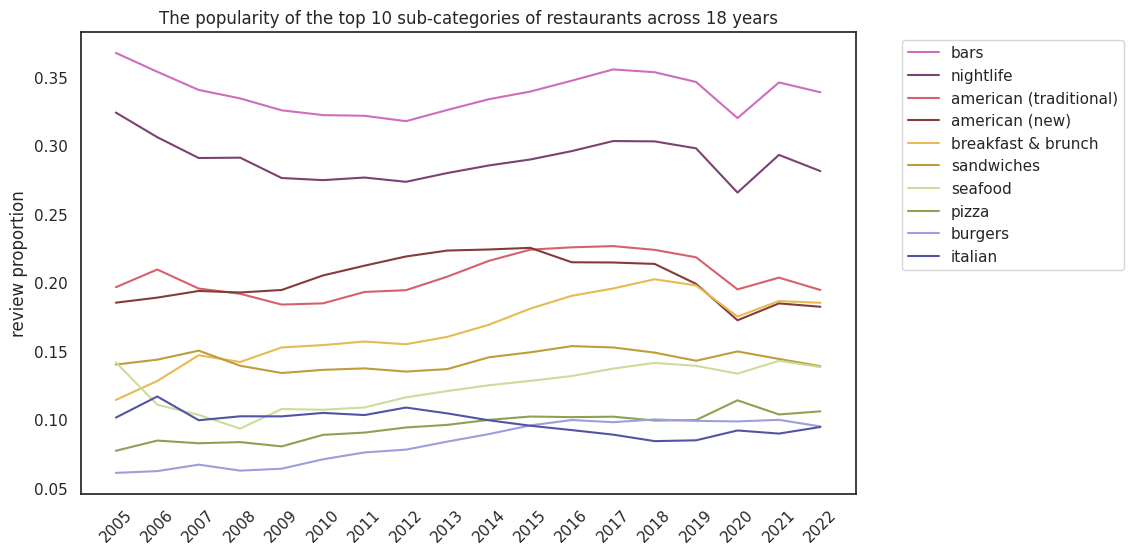

In [37]:
plt.figure(figsize=(10, 6))
sns.lineplot(data = df_long, x = 'year', y = 'proportion', hue = 'subcat', palette = 'tab20b_r')
#ax.bar_label(ax.containers[0])
plt.title('The popularity of the top 10 sub-categories of restaurants across 18 years')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('')
plt.ylabel('review proportion')

#### Yelp restaurant reviews and stars over time

In [38]:
df_all['date'] = pd.to_datetime(df_all['date'])
# Extract year and month from the date column
df_all['Year_Month'] = df_all['date'].dt.strftime('%Y-%m')
ts = df_all.groupby(['Year_Month']).agg({'review_id' : 'count',
                                         'business_id' : 'nunique',
                                         'user_id' : 'nunique',
                                         'stars' : 'mean',
                                         'review_length' : 'mean',
                                         'rev_polarity_x' : 'mean'}).reset_index()

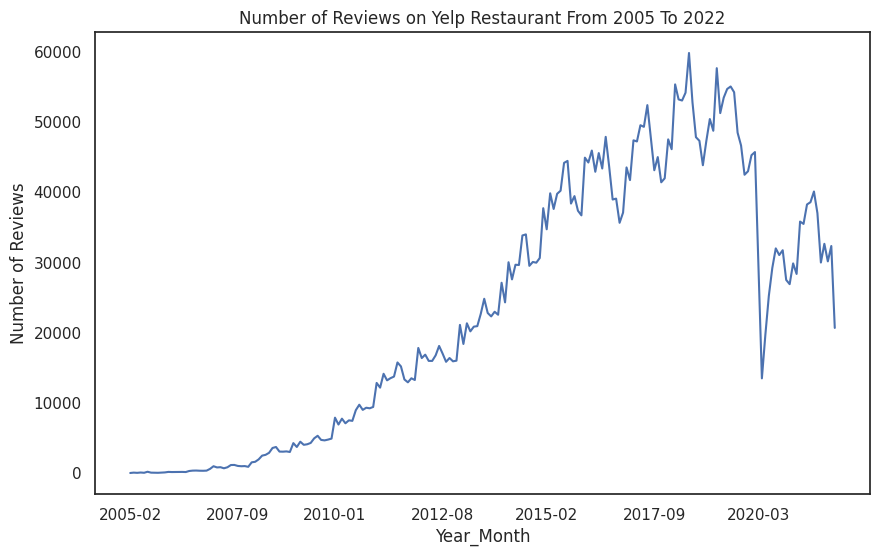

In [39]:
plt.figure(figsize=(10, 6))
ax = sns.lineplot(ts, x = 'Year_Month', y = 'review_id')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews on Yelp Restaurant From 2005 To 2022')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

(1.0, 5.0)

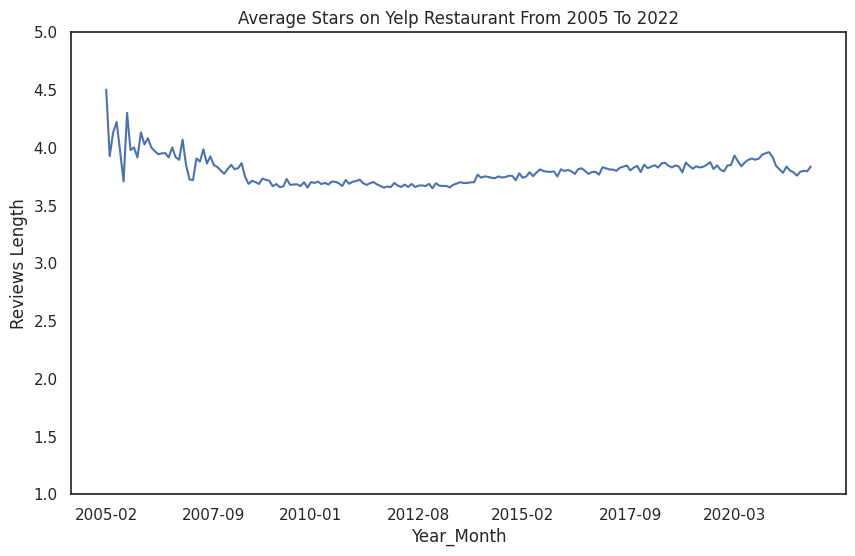

In [40]:
plt.figure(figsize=(10, 6))
ax = sns.lineplot(ts, x = 'Year_Month', y = 'stars')
plt.ylabel('Reviews Length')
plt.title('Average Stars on Yelp Restaurant From 2005 To 2022')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_ylim(1,5)

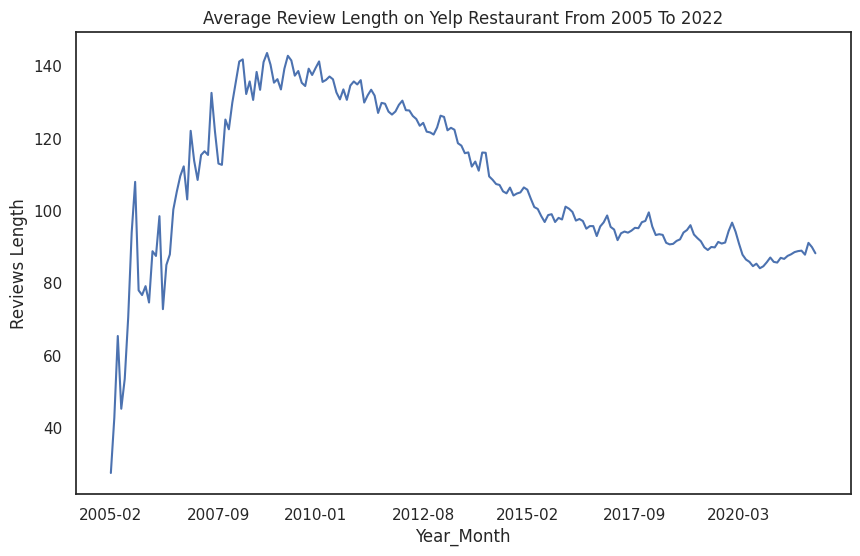

In [41]:
plt.figure(figsize=(10, 6))
ax = sns.lineplot(ts, x = 'Year_Month', y = 'review_length')
plt.ylabel('Reviews Length')
plt.title('Average Review Length on Yelp Restaurant From 2005 To 2022')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

#### The preference changing over years from the top user who gave the most reviews

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, '2005'),
  Text(1, 0, '2006'),
  Text(2, 0, '2007'),
  Text(3, 0, '2008'),
  Text(4, 0, '2009'),
  Text(5, 0, '2010'),
  Text(6, 0, '2011'),
  Text(7, 0, '2012'),
  Text(8, 0, '2013'),
  Text(9, 0, '2014'),
  Text(10, 0, '2015'),
  Text(11, 0, '2016'),
  Text(12, 0, '2017'),
  Text(13, 0, '2018'),
  Text(14, 0, '2019'),
  Text(15, 0, '2020'),
  Text(16, 0, '2021'),
  Text(17, 0, '2022')])

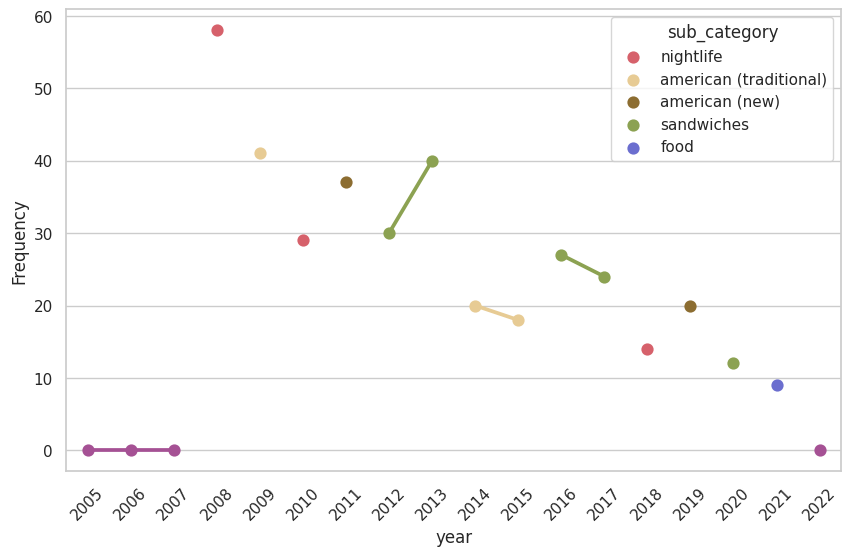

In [42]:
case = df_all[df_all['user_id'] == '_BcWyKQL16ndpBdggh2kNA']
year_list = list(np.arange(2005,2023))
subtype = []

for i in range(0,len(year_list)):
    sub = case[case['year'] == year_list[i]]
    all_categories = ','.join(sub['categories'].dropna()).lower().split(',')
    all_categories = [category.strip() for category in all_categories]
    category_counts = Counter(all_categories)
    most_common_categories = category_counts.most_common(5)
    if most_common_categories[0] == ('', 1):
        subtype.append(('', 0))
    else: subtype.append(most_common_categories[2])
        
sub_category = []
count = []
for i in range(0,len(year_list)):
    sub_category.append(subtype[i][0])
    count.append(subtype[i][1])

df = pd.DataFrame(data = {'year' : year_list,
                          'sub_category' : sub_category,
                          'count' : count})

df['year'] = df['year'].astype(str)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.pointplot(df, x = 'year', y = 'count', hue = 'sub_category', palette = 'tab20b_r')
plt.ylabel('Frequency')
plt.xticks(rotation = 45)

### Word Cloud for restaurant reviews

#### Word Cloud

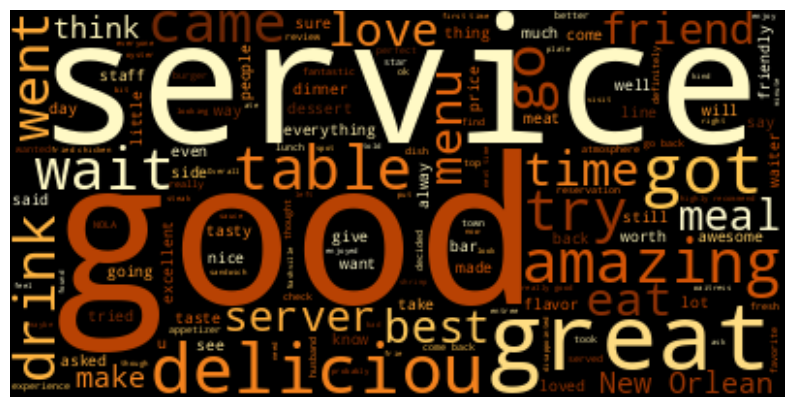

In [43]:
# for the restaurants that have more than 1000 reviews
busi_num = df_review_restaurant.groupby(['business_id']).agg({'review_id':'count','stars':'mean', 'rev_polarity' : 'mean'}).reset_index()
mostReviewList = busi_num[busi_num['review_id'] >= 1000]['business_id'].tolist()
case1 = df_review_restaurant[df_review_restaurant['business_id'].isin(mostReviewList)]

text1 = ""
for i in range(0, len(case1)):
    text1 = text1 + case1['text'].iloc[i]

# Create and generate a word cloud image:
stopwords = set(STOPWORDS)
stopwords.update(["place", "food", "restaurant", "ordered", "order", "one"])
wordcloud = WordCloud(stopwords=stopwords, background_color="black", colormap = 'YlOrBr').generate(text1)

# Display the generated image:
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

####  The frequency of positive/negative words in the review

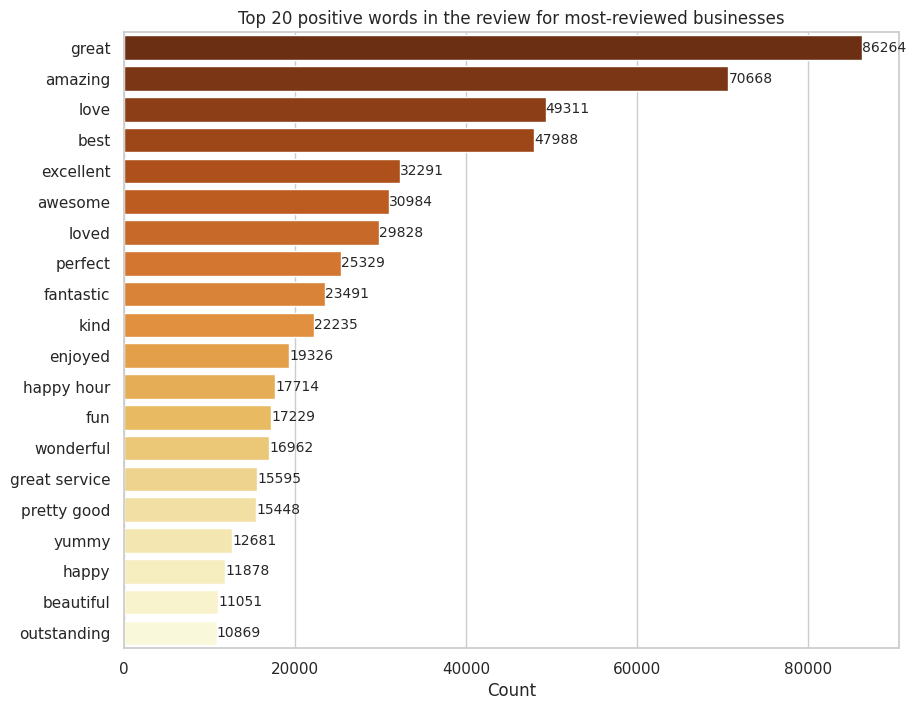

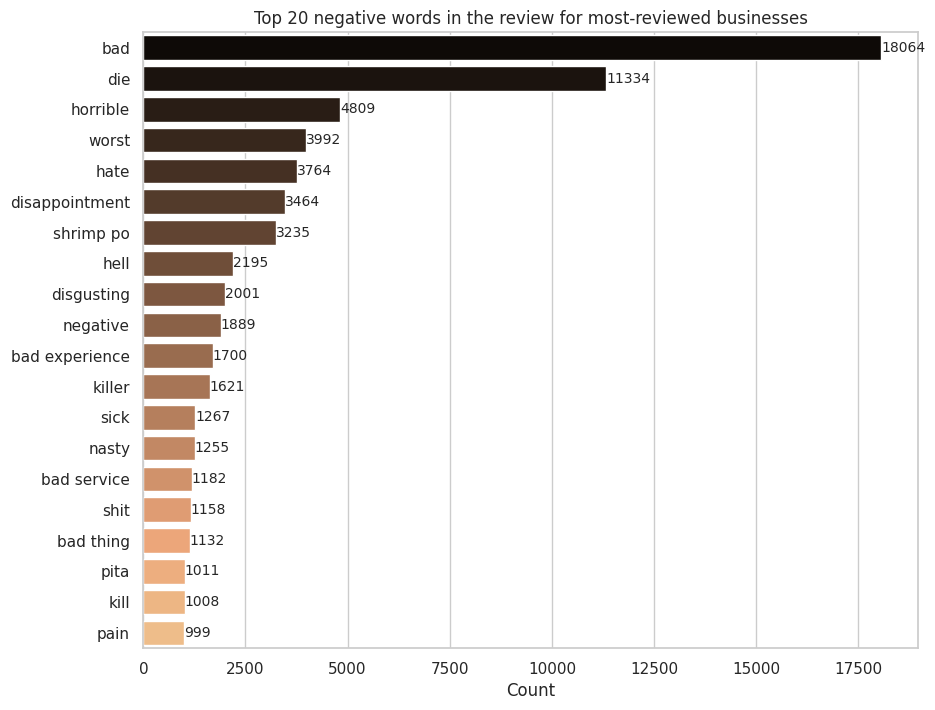

In [44]:
freqWords = WordCloud(stopwords=stopwords).process_text(text1)
s = sorted(freqWords.items(), key=lambda x: x[1], reverse=True)

# count the frequency of positive words
count = 0
pos_select = []
pos_select_count = []
sentiment = SentimentIntensityAnalyzer()
for i in range(0, len(s)):
    if sentiment.polarity_scores(s[i][0])['compound'] >= 0.5:
        count = count + 1
        pos_select.append(s[i][0])
        pos_select_count.append(s[i][1])
    if count == 20:
        break;

# count the frequency of negative words
count = 0
neg_select = []
neg_select_count = []
sentiment = SentimentIntensityAnalyzer()
for i in range(0, len(s)):
    if sentiment.polarity_scores(s[i][0])['compound'] <= -0.5:
        count = count + 1
        neg_select.append(s[i][0])
        neg_select_count.append(s[i][1])
    if count == 22:  # adjusted
        break;

# plot: 
# Remove the irreasonable negative word detected: po boy (a sandwich)
list = [1,9]
for i in list:
    del neg_select[i]
    del neg_select_count[i]

sns.set(style="whitegrid")

plt.figure(figsize=(10,8))
ax = sns.barplot(x = pos_select_count, y = pos_select, palette = 'YlOrBr_r', errorbar = None)
ax.bar_label(ax.containers[0], fontsize = 10)
plt.title('Top 20 positive words in the review for most-reviewed businesses')
plt.xlabel('Count')
plt.show

plt.figure(figsize=(10,8))
ax2 = sns.barplot(x = neg_select_count, y = neg_select, palette = 'copper', errorbar = None)
ax2.bar_label(ax2.containers[0], fontsize = 10)
plt.title('Top 20 negative words in the review for most-reviewed businesses')
plt.xlabel('Count')
plt.show()

## Exploratory Data Analysis - Part2: User Grouping (multi-review user VS. single-review user)

In [45]:
df_active = df_all[df_all['user_activity'] == "Active User"]     # multi-review group
df_nonactive = df_all[df_all['user_activity'] == "Non-active User"]     # single-review group

### Descriptive statistics

Note: 
1. active user: users in multi-review group
2. non-active user: users in single-review group

In [56]:
n1 = df_user_restaurant[(df_user_restaurant['user_activity'] == "Non-active User")].shape[0] 
n2 = df_user_restaurant[(df_user_restaurant['user_activity'] == "Active User")].shape[0] 
p1 = round(n1 / df_user_restaurant.shape[0] * 100, 2)
p2 = round(n2 / df_user_restaurant.shape[0] * 100, 2)
print(f"Number of users in single-review group: {n1}, taking {p1}% proportion. ")
print(f"Number of users in multi-review group: {n2}, taking {p2}% proportion. ")

Number of users in single-review group: 838531, taking 58.09% proportion. 
Number of users in multi-review group: 604949, taking 41.91% proportion. 


In [57]:
n1 = df_all[(df_all['user_activity'] == "Non-active User")].shape[0] 
n2 = df_all[(df_all['user_activity'] == "Active User")].shape[0] 
p1 = round(n1 / df_all.shape[0] * 100, 2)
p2 = round(n2 / df_all.shape[0] * 100, 2)
print(f"Number of reviews in single-review group: {n1}, taking {p1}% proportion. ")
print(f"Number of reviews in multi-review group: {n2}, taking {p2}% proportion. ")

Number of reviews in single-review group: 838531, taking 17.8% proportion. 
Number of reviews in multi-review group: 3870991, taking 82.19% proportion. 


In [48]:
df_all.groupby(['user_activity']).agg({'stars' : 'mean',
                                               'business_stars' : 'mean',
                                               'review_length' : 'mean',
                                               'rev_polarity_x' : 'mean'})

,stars,business_stars,review_length,rev_polarity_x
user_activity,,,,
Active User,3.822892,3.798117,104.442923,0.703769
Non-active User,3.656401,3.765909,81.587310,0.569879


In [49]:
df_all.groupby(['user_activity']).agg({'compliment_total' : 'median',
                                   'fans' : 'median',
                                   'elites_count' : 'median',
                                   'user_useful' : 'median',
                                   'user_funny' : 'median',
                                   'user_cool' : 'median'})

,compliment_total,fans,elites_count,user_useful,user_funny,user_cool
user_activity,,,,,,
Active User,3.0,1.0,0.0,32.0,6.0,9.0
Non-active User,0.0,0.0,0.0,2.0,0.0,0.0


In [50]:
p1 = df_active[df_active['compliment_total'] == 0].shape[0] / df_active.shape[0]
print(f"The proportion of users whose total compliments was 0 in the multi-review group is {p1}")
p2 = df_nonactive[df_nonactive['compliment_total'] == 0].shape[0] / df_nonactive.shape[0]
print(f"The proportion of users whose total compliments was 0 in the single-review group is {p2}")
p3 = df_active[df_active['fans'] == 0].shape[0] / df_active.shape[0]
print(f"The proportion of users whose fans was 0 in the multi-review group is {p3}")
p4 = df_nonactive[df_nonactive['fans'] == 0].shape[0] / df_nonactive.shape[0]
print(f"The proportion of users whose fans was 0 in the multi-review group is {p4}")

The proportion of users whose total compliments was 0 in the multi-review group is 0.2856219505547804
The proportion of users whose total compliments was 0 in the single-review group is 0.7457517968924225
The proportion of users whose fans was 0 in the multi-review group is 0.43662488494548296
The proportion of users whose fans was 0 in the multi-review group is 0.8339989815522623


In [51]:
df_all.groupby(['user_activity']).agg({'review_length' : 'mean',
                                       'stars' : 'mean',
                                       'rev_polarity_x' : 'mean'}).reset_index()

,user_activity,review_length,stars,rev_polarity_x
0,Active User,104.442923,3.822892,0.703769
1,Non-active User,81.587310,3.656401,0.569879


In [52]:
df_all.groupby(['stars','user_activity']).agg({'review_length' : 'mean',
                                               'rev_polarity_x' : 'mean'}).reset_index()

,stars,user_activity,review_length,rev_polarity_x
0,1,Active User,120.724900,-0.113917
1,1,Non-active User,111.555930,-0.198363
2,2,Active User,132.131901,0.322761
3,2,Non-active User,114.485452,0.216881
4,3,Active User,124.568046,0.660699
5,3,Non-active User,99.689738,0.531376
6,4,Active User,109.161749,0.858500
7,4,Non-active User,76.835665,0.829989
8,5,Active User,85.917332,0.891058
9,5,Non-active User,63.147434,0.883323


### The distribution of stars

(0.0, 60.0)

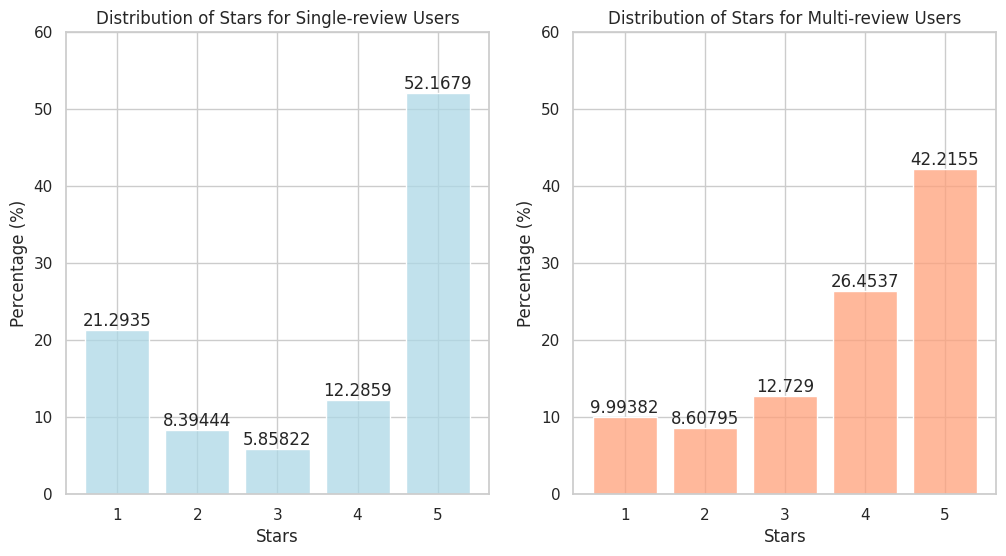

In [53]:
# filter by the categories: keep the restaurant 
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.color_palette("dark:salmon_r", as_cmap=True)

plt.subplot(1,2,1)
ax = sns.histplot(df_all[df_all['user_activity'] == 'Non-active User'], 
                  x='stars', discrete=True, shrink = 0.8, stat = 'percent', color = 'lightblue')
ax.bar_label(ax.containers[0], fmt='%.2f')
plt.title("Distribution of Stars for Single-review Users")
plt.ylabel('Percentage (%)')
plt.xlabel('Stars')
ax.set_ylim(0,60)

plt.subplot(1,2,2)
ax2 = sns.histplot(df_all[df_all['user_activity'] == 'Active User'], 
                   x='stars', discrete=True, shrink = 0.8, stat = 'percent', color = 'lightsalmon')
ax2.bar_label(ax2.containers[0], fmt='%.2f')
plt.title("Distribution of Stars for Multi-review Users")
plt.ylabel('Percentage (%)')
plt.xlabel('Stars')
ax2.set_ylim(0,60)

### The correlation between average stars, review polarity, review subjectivity and review length in multi-review group and single-review group

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]),
 [Text(0.5, 0, 'stars'),
  Text(1.5, 0, 'review_useful'),
  Text(2.5, 0, 'review_funny'),
  Text(3.5, 0, 'review_cool'),
  Text(4.5, 0, 'rev_polarity_x'),
  Text(5.5, 0, 'rev_subjectivity'),
  Text(6.5, 0, 'year'),
  Text(7.5, 0, 'review_length'),
  Text(8.5, 0, 'business_stars'),
  Text(9.5, 0, 'review_count_x'),
  Text(10.5, 0, 'yelping_since'),
  Text(11.5, 0, 'friends_count'),
  Text(12.5, 0, 'elites_count'),
  Text(13.5, 0, 'fans'),
  Text(14.5, 0, 'compliment_total')])

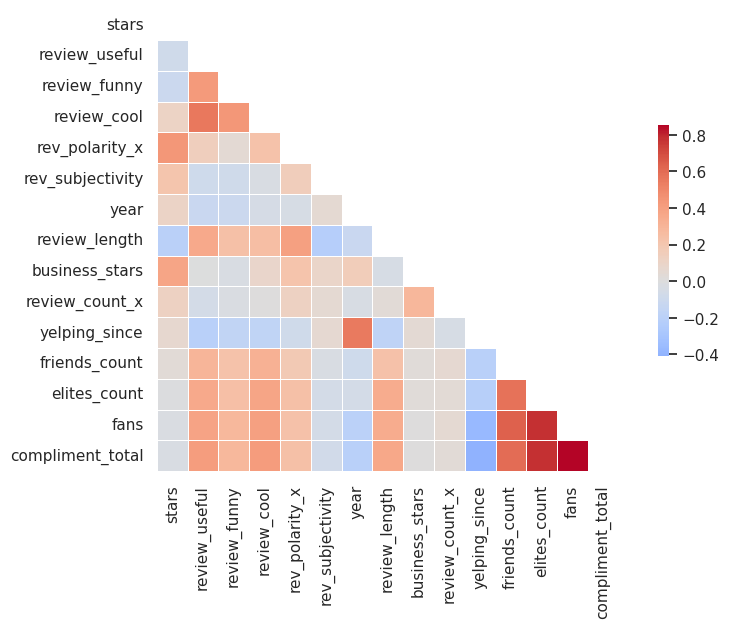

In [54]:
# multi-review group

sns.set_theme(style="white")
df_corr = df_active[['stars', 'review_useful','review_funny', 'review_cool', 'rev_polarity_x', 'rev_subjectivity', 
                  'year', 'review_length', 'business_stars','review_count_x',  'yelping_since', 
                  'friends_count', 'elites_count', 'fans', 'compliment_total']] 

# Compute the correlation matrix
corr = df_corr.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap = 'coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=90)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]),
 [Text(0.5, 0, 'stars'),
  Text(1.5, 0, 'review_useful'),
  Text(2.5, 0, 'review_funny'),
  Text(3.5, 0, 'review_cool'),
  Text(4.5, 0, 'rev_polarity_x'),
  Text(5.5, 0, 'rev_subjectivity'),
  Text(6.5, 0, 'year'),
  Text(7.5, 0, 'review_length'),
  Text(8.5, 0, 'business_stars'),
  Text(9.5, 0, 'review_count_x'),
  Text(10.5, 0, 'yelping_since'),
  Text(11.5, 0, 'friends_count'),
  Text(12.5, 0, 'elites_count'),
  Text(13.5, 0, 'fans'),
  Text(14.5, 0, 'compliment_total')])

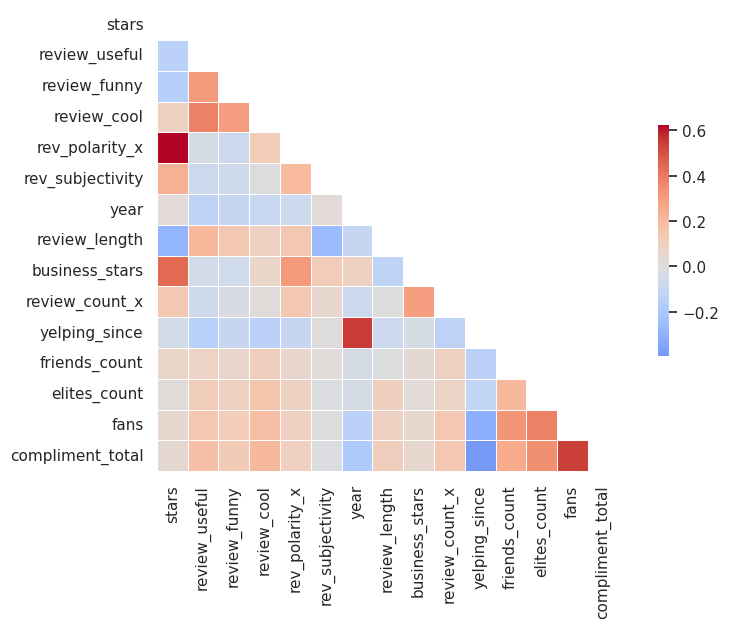

In [55]:
# single-review group

sns.set_theme(style="white")
df_corr2 = df_nonactive[['stars', 'review_useful','review_funny', 'review_cool', 'rev_polarity_x', 'rev_subjectivity', 
                  'year', 'review_length', 'business_stars','review_count_x',  'yelping_since', 
                  'friends_count', 'elites_count', 'fans', 'compliment_total']] 

# Compute the correlation matrix
corr = df_corr2.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap = 'coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=90)